## 기존의 Mytorch를 가변으로 확장

In [1]:
import numpy as np


class MyTorch:
    def __init__(self, data: "np.ndarray"):
        """
        MyTorch 클래스는 데이터와 기울기(grad) 정보를 저장하는 변수입니다.

        매개변수:
        - data (np.ndarray): 저장할 데이터입니다. 스칼라 또는 numpy 배열 형태여야 합니다.

        예외:
        - TypeError: data가 np.ndarray가 아닐 경우 발생합니다.

        예시:
        >>> x = MyTorch(np.array(2.0))
        >>> x.data
        array(2.)
        """
        if data is not None:
            # ! 인스턴스 변수가 현재 넘파이만 받도록 설정
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None # 역전파시 미분값을 저장
        self.creator = None # 순전파 통과시 만들어진 결과 인스터스의 생성자 함수 인스턴스를 저장

    def set_creator(self, func: 'Function'):
        """
        MyTorch 인스턴스의 creator를 설정합니다.

        매개변수:
        - func (Function): 이 변수를 생성한 함수 인스턴스입니다.

        예시:
        >>> f = Square()
        >>> x = MyTorch(np.array(2.0))
        >>> x.set_creator(f)
        >>> x.creator
        <__main__.Square object at 0x...>
        """
        self.creator = func

    def backward(self):
        """
        역전파를 수행하여 기울기를 계산합니다.

        동작:
        - 기울기가 None인 경우 1로 초기화하고, creator를 통해 역전파를 수행합니다.

        예시:
        >>> x = MyTorch(np.array(3.0))
        >>> y = square(x)
        >>> y.backward()
        >>> x.grad
        array(6.)
        """
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            x, y = f.input, f.output
            x.grad = f.backward(y.grad)

            if x.creator is not None:
                funcs.append(x.creator)


def as_array(x: float) -> np.ndarray:
    """
    입력값을 np.ndarray로 변환합니다.

    매개변수:
    - x (float or np.ndarray): 변환할 값.

    반환값:
    - np.ndarray: 변환된 배열.

    예시:
    >>> as_array(1.0)
    array(1.)
    >>> as_array(np.array([1, 2, 3]))
    array([1, 2, 3])
    """
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, input: MyTorch) -> MyTorch:
        """
        함수 호출 메서드입니다. 입력값을 받아 forward를 실행하고 출력을 생성합니다.

        매개변수:
        - input (MyTorch): MyTorch 인스턴스.

        반환값:
        - MyTorch: 함수의 출력을 포함하는 MyTorch 인스턴스.

        예시:
        >>> x = MyTorch(np.array(2.0))
        >>> y = Square()(x)
        >>> y.data
        array(4.)
        """
        x = input.data
        y = self.forward(x) # 하위 class 의 함수에서 통과
        output = MyTorch(as_array(y))
        output.set_creator(self)
        self.input = input # F은 입력 Mytorch 인스턴스 저장
        self.output = output # F은 출력 Mytorch 인스턴스 저장
        return output

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        주어진 입력값에 대해 함수의 출력을 계산합니다.

        매개변수:
        - x (np.ndarray): 입력 데이터.

        반환값:
        - np.ndarray: 출력값.

        예시:
        >>> f = Square()
        >>> f.forward(np.array(2.0))
        array(4.)
        """
        raise NotImplementedError()

    def backward(self, gy: np.ndarray) -> np.ndarray:
        """
        주어진 기울기에 대해 입력값의 기울기를 계산합니다.

        매개변수:
        - gy (np.ndarray): 출력에 대한 기울기.

        반환값:
        - np.ndarray: 입력값의 기울기.

        예시:
        >>> f = Square()
        >>> f.backward(np.array(1.0))
        """
        raise NotImplementedError()


class Square(Function):
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        입력값의 제곱을 계산합니다.

        매개변수:
        - x (np.ndarray): 입력 데이터.

        반환값:
        - np.ndarray: 입력값의 제곱.

        예시:
        >>> f = Square()
        >>> f.forward(np.array(3.0))
        array(9.)
        """
        y = x ** 2
        return y

    def backward(self, gy: np.ndarray) -> np.ndarray:
        """
        제곱 함수에 대한 기울기를 계산합니다.

        매개변수:
        - gy (np.ndarray): 제곱 함수의 출력에 대한 기울기.

        반환값:
        - np.ndarray: 입력값의 기울기.

        예시:
        >>> f = Square()
        >>> f.input = MyTorch(np.array(3.0))  # 가정
        >>> f.backward(np.array(1.0))
        array(6.)
        """
        x = self.input.data
        gx = 2 * x * gy
        return gx


def square(x: MyTorch) -> MyTorch:
    """
    MyTorch 인스턴스에 대해 제곱 함수를 적용합니다.

    매개변수:
    - x (MyTorch): 입력 데이터.

    반환값:
    - MyTorch: 제곱 값을 포함하는 MyTorch 인스턴스.

    예시:
    >>> x = MyTorch(np.array(2.0))
    >>> y = square(x)
    >>> y.data
    array(4.)
    """
    return Square()(x)


In [2]:
x = MyTorch(np.array(0.5))  # MyTorch 인스턴스 생성
y = square(square(square(x)))  # 함수 체이닝을 통한 연산
y.backward()  # 역전파 호출

#//* 보통 맨 마지막 단 입력값의 결과값에 대한 기울기을 필요로 한다.
x.grad

0.0625

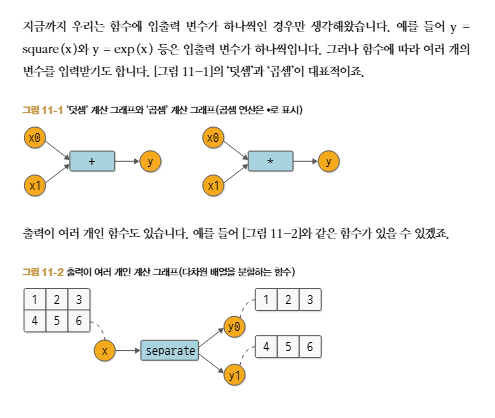
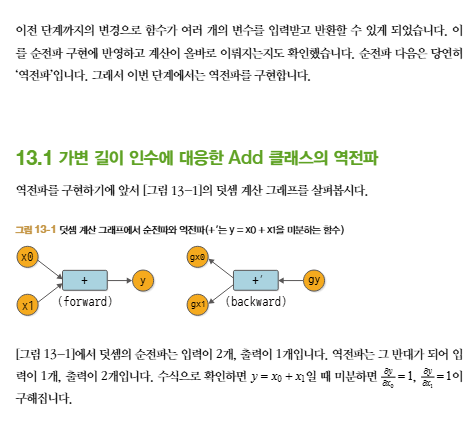

In [3]:

# ! 가변 인수 이해하기.

def test_print(*inputs):
    print(type(inputs),len(inputs)) # 내부에서 타입을 튜플로 묶어줌
    #print(type(*inputs),len(*inputs))
    return print([_.data for _ in inputs])

data=[MyTorch(np.array(i)) for i in range(3)]
data

In [4]:
test_print(*data) # test print에 *가 없으면 TypeError: test_print() takes 1 positional argument but 3 were given


<class 'tuple'> 3
[array(0), array(1), array(2)]


In [5]:
test_print(MyTorch(np.array(1)),MyTorch(np.array(2)),MyTorch(np.array(3)))

<class 'tuple'> 3
[array(1), array(2), array(3)]


In [6]:
test_print(MyTorch(np.array(1)))

<class 'tuple'> 1
[array(1)]


In [7]:
test_print(*[MyTorch(np.array(1)),MyTorch(np.array(1))])

<class 'tuple'> 2
[array(1), array(1)]


In [8]:
test_print(data)

<class 'tuple'> 1


AttributeError: 'list' object has no attribute 'data'

### 여러 값을 동시에 받는 가변인수 함수는 내부에서 *변수로 튜플로 묶어줘서 처리해줌
`func(*xs)==func(x0,x1)`

In [12]:
# 가변 인수

def test_print(inputs):
    print(type(inputs),len(inputs)) # 내부에서 타입을 튜플로 묶어줌
    for _ in inputs:
        print(_.data) 

    return print([_.data for _ in inputs])

data=[MyTorch(np.array(i)) for i in range(3)]
data

In [13]:
test_print(data) # test print에 *가 없으면 TypeError: test_print() takes 1 positional argument but 3 were given


<class 'list'> 3
0
1
2
[array(0), array(1), array(2)]


In [14]:
test_print(MyTorch(np.array(1)),MyTorch(np.array(2)),MyTorch(np.array(3)))

TypeError: test_print() takes 1 positional argument but 3 were given

### 함수에 *가 없으면 튜플 처리를 못해줘서 인력 자체가 안됨

In [15]:
def add(xs):
    x0,x1=xs
    y=x0+x1
    return (y,)

print(f"함수에서 반환하는 값{add([1,3])}, 튜플에서 데이터 꺼내기 {add([1,3])[0]}")

# print(f"함수에서 반환하는 값{add([MyTorch(np.array(3)),MyTorch(np.array(5))])}, 튜플에서 데이터 꺼내기 {add([MyTorch(np.array(3)),MyTorch(np.array(5))])[0]}")

함수에서 반환하는 값(4,), 튜플에서 데이터 꺼내기 4


In [18]:
import numpy as np


class Mytorch:
    """ 
    Mytorch 클래스는 데이터와 기울기를 저장하는 클래스입니다.
    
    Attributes:
        data (np.ndarray): 변수의 데이터를 저장합니다.
        grad (np.ndarray): 변수의 기울기를 저장합니다.
        creator (Function): 이 변수를 생성한 함수를 저장합니다.
    """
    
    def __init__(self, data):
        """
        Mytorch 객체를 초기화합니다.

        Args:
            data (np.ndarray or None): 변수의 데이터로 사용할 NumPy 배열.
        
        Raises:
            TypeError: 입력 데이터가 NumPy 배열이 아닌 경우.
        """
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        """ 
        이 변수를 생성한 함수를 설정합니다.

        Args:
            func (Function): 이 변수를 생성한 함수.
        """
        self.creator = func

    def backward(self):
        """
        역전파를 수행하여 기울기를 계산합니다.
        """
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            x, y = f.inputs, f.outputs  # 수정: inputs와 outputs 사용
            # ! fucntion class 에서는 inputs을 가변으로 받아 튜블로 가지고있기 때문에 
            # ! 다음과같이 인덱스로 접근해야한다.

            # ! 결과값또한 튜플로 만들어주고 있음
            x[0].grad = f.backward(y[0].grad)  # 수정: 첫 번째 입력만 사용

            if x[0].creator is not None:
                funcs.append(x[0].creator)


def as_array(x):
    """
    스칼라 값을 NumPy 배열로 변환합니다.

    Args:
        x (scalar or np.ndarray): 변환할 값.

    Returns:
        np.ndarray: 입력이 스칼라인 경우 배열로 변환된 값.
    """
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    """ 
    Function 클래스는 사용자 정의 함수의 기본 클래스입니다.
    
    Methods:
        forward(xs): 주어진 입력에 대해 순전파를 수행합니다.
        backward(gys): 주어진 기울기에 대해 역전파를 수행합니다.
    """
    
    def __call__(self, *inputs):
        """
        함수 호출을 처리합니다.

        Args:
            *inputs (Mytorch): 입력 변수들.
        
        Returns:
            Mytorch or tuple of Mytorch: 출력 변수를 반환합니다.
        """
        # ! 가변 인수로 받아서 값을 저장함.
        xs = [x.data for x in inputs] # ! (Mytorch) 인스턴스에서 각 data 속성을  꺼내옴
        
        # ! 값을 확인하기 ,xs 리스트 타입임.
        print(f"인풋 리스트에 들어가 있는 Mytoch의 객체의 수: {len(xs)}, {xs}")
        
        ys = self.forward(*xs)

        print(f"튜플로 감싸 주기 전의 값 ys의 값: {ys}")

        if not isinstance(ys, tuple):
            ys = (ys,)
        
        print(f"튜플로 감싼 ys의 값: {ys}")

        outputs = [Mytorch(as_array(y)) for y in ys] # 결과값을 다시 묶어줌

        print(f"연산의 결과 Mytorch 결과 값: {outputs}, 데이터의 길이 {len(outputs)}")

        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs

        print(self.inputs)

        self.outputs = outputs
        
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, *xs):
        """ 
        주어진 입력에 대해 순전파를 수행합니다.
        서브클래스에서 구현해야 합니다.
        
        Args:
            *xs: 순전파에 사용할 입력들.
        
        Returns:
            Output: 순전파 결과.
        """
        raise NotImplementedError()

    def backward(self, gys):
        """ 
        주어진 기울기에 대해 역전파를 수행합니다.
        서브클래스에서 구현해야 합니다.
        
        Args:
            gys: 입력 기울기.
        
        Returns:
            List of np.ndarray: 입력에 대한 기울기.
        """
        raise NotImplementedError()


class Add(Function):
    """ 
    두 변수를 더하는 클래스입니다.
    """
    
    # 언패킹으로 튜플이 풀어져서 들어옴
    def forward(self, x0,x1):
        """
        두 입력을 더합니다.

        Args:
            x0 (np.ndarray): 첫 번째 입력.
            x1 (np.ndarray): 두 번째 입력.

        Returns:
            np.ndarray: 두 입력의 합.
        """
        y = x0 + x1
        #y=np.sum(xs) *xs
        return y


def add(x0, x1):
    """
    두 Mytorch 객체를 더하는 함수입니다.

    Args:
        x0 (Mytorch): 첫 번째 입력 Mytorch.
        x1 (Mytorch): 두 번째 입력 Mytorch.

    Returns:
        Mytorch: 두 입력의 합을 포함하는 새로운 Mytorch.
    
    Example:
        >>> x0 = Mytorch(np.array(2))
        >>> x1 = Mytorch(np.array(3))
        >>> y = add(x0, x1)
        >>> print(y.data)  # 출력: 5
    """
    return Add()(x0, x1)


class Square(Function):
    """ 제곱 함수 클래스 """
    
    def forward(self, input):
        """ 
        입력된 값의 제곱을 계산합니다.
        """
        # Ensure input.data is an ndarray (convert memoryview to ndarray)
        data = np.asarray(input.data)
        y = data ** 2
        return y

    def backward(self, gy):
        """ 
        제곱 함수의 기울기 계산: 2 * x * gy
        """
        # Ensure input.data is an ndarray (convert memoryview to ndarray)
        data = np.asarray(self.inputs[0].data)
        return 2 * data * gy
    
    
# 사용 예시
x0 = Mytorch(np.array(2))
x1 = Mytorch(np.array(3))
y = add(x0, x1)
print(type(y),y.data)  # 출력: 5


인풋 리스트에 들어가 있는 Mytoch의 객체의 수: 2, [array(2), array(3)]
튜플로 감싸 주기 전의 값 ys의 값: 5
튜플로 감싼 ys의 값: (5,)
연산의 결과 Mytorch 결과 값: [<__main__.Mytorch object at 0x000002F77EF92390>], 데이터의 길이 1
(<__main__.Mytorch object at 0x000002F77E948650>, <__main__.Mytorch object at 0x000002F77E948110>)
<class '__main__.Mytorch'> 5


In [19]:
y = square(x0)
y

인풋 리스트에 들어가 있는 Mytoch의 객체의 수: 1, [array(2)]
튜플로 감싸 주기 전의 값 ys의 값: 4
튜플로 감싼 ys의 값: (4,)
연산의 결과 Mytorch 결과 값: [<__main__.Mytorch object at 0x000002F77EF92EA0>], 데이터의 길이 1
(<__main__.Mytorch object at 0x000002F77E948650>,)


In [20]:
Mytorch(np.array([2,3])).data

array([2, 3])

In [21]:
x2=Mytorch(np.array([[2,3],[2,3]]))
x3=Mytorch(np.array([[2,3],[2,3]]))
y = add(x2, x3)
print(type(y),y.data)  

인풋 리스트에 들어가 있는 Mytoch의 객체의 수: 2, [array([[2, 3],
       [2, 3]]), array([[2, 3],
       [2, 3]])]
튜플로 감싸 주기 전의 값 ys의 값: [[4 6]
 [4 6]]
튜플로 감싼 ys의 값: (array([[4, 6],
       [4, 6]]),)
연산의 결과 Mytorch 결과 값: [<__main__.Mytorch object at 0x000002F77E459310>], 데이터의 길이 1
(<__main__.Mytorch object at 0x000002F77EF9DE20>, <__main__.Mytorch object at 0x000002F77EF9F980>)
<class '__main__.Mytorch'> [[4 6]
 [4 6]]


In [22]:
def my_func(*args):
    print(args)

my_func(1, 2, 3)  # 출력: (1, 2, 3)


(1, 2, 3)


In [23]:
args = (1, 2, 3)
my_func(*args)  # 출력: (1, 2, 3)

(1, 2, 3)


In [24]:
my_func(args)

((1, 2, 3),)


In [25]:
my_func(1,2,3)

(1, 2, 3)


In [26]:
y.grad

In [27]:
x0.grad

In [28]:
x0 = Mytorch(np.array([2,3]))
x1 = Mytorch(np.array([3,5]))

In [29]:
x0.data,x1.data

(array([2, 3]), array([3, 5]))

In [30]:
y = add(x0, x1)
y.data

인풋 리스트에 들어가 있는 Mytoch의 객체의 수: 2, [array([2, 3]), array([3, 5])]
튜플로 감싸 주기 전의 값 ys의 값: [5 8]
튜플로 감싼 ys의 값: (array([5, 8]),)
연산의 결과 Mytorch 결과 값: [<__main__.Mytorch object at 0x000002F77EF90A10>], 데이터의 길이 1
(<__main__.Mytorch object at 0x000002F77EC6E7E0>, <__main__.Mytorch object at 0x000002F77EC84EF0>)


array([5, 8])

In [31]:
y = square(x0)
y.data

인풋 리스트에 들어가 있는 Mytoch의 객체의 수: 1, [array([2, 3])]
튜플로 감싸 주기 전의 값 ys의 값: [4 9]
튜플로 감싼 ys의 값: (array([4, 9]),)
연산의 결과 Mytorch 결과 값: [<__main__.Mytorch object at 0x000002F77EF93800>], 데이터의 길이 1
(<__main__.Mytorch object at 0x000002F77EC6E7E0>,)


array([4, 9])

In [32]:
np.array([4, 9]) ** 2

array([16, 81])

In [33]:
y.__class__

__main__.Mytorch

$z=x^2+y^2$

미분

In [34]:
import numpy as np


class Mytorch:
    """ 
    Mytorch 클래스는 데이터와 기울기를 저장하는 클래스입니다.
    
    Attributes:
        data (np.ndarray): 변수의 데이터를 저장합니다.
        grad (np.ndarray): 변수의 기울기를 저장합니다.
        creator (Function): 이 변수를 생성한 함수를 저장합니다.
    """
    
    def __init__(self, data):
        """
        Mytorch 객체를 초기화합니다.

        Args:
            data (np.ndarray or None): 변수의 데이터로 사용할 NumPy 배열.
        
        Raises:
            TypeError: 입력 데이터가 NumPy 배열이 아닌 경우.
        """
        if data is not None: # 타입을 검사함
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data # 마이토치 데이터 속성
        self.grad = None # 인스턴스의 기울기
        self.creator = None # 인스턴스가 어떤 함수를 걸쳐서 생성됐으면 그 함수의 주소를 저장

    def set_creator(self, func):
        """ 
        이 변수를 생성한 함수를 설정합니다.

        Args:
            func (Function): 이 변수를 생성한 함수.
        """
        self.creator = func

    def backward(self):
        """
        역전파를 수행하여 기울기를 계산합니다.
        """
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()

            print(f" f를 추출 {f}")

            #! f.outputs에 저장된 출력 변수들의 기울기를 gys에 저장
            
            gys = [output.grad for output in f.outputs]

            #! f.backward를 호출하여 출력 기울기를 사용해 입력 기울기(gxs)를 계산
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            #! f.inputs와 gxs를 순회하며 각 입력 변수의 기울기(x.grad)를 업데이트
            for x, gx in zip(f.inputs, gxs):
                x.grad = gx

                if x.creator is not None:
                    funcs.append(x.creator)


def as_array(x):
    """
    스칼라 값을 NumPy 배열로 변환합니다.

    Args:
        x (scalar or np.ndarray): 변환할 값.

    Returns:
        np.ndarray: 입력이 스칼라인 경우 배열로 변환된 값.
    """
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    """ 
    Function 클래스는 사용자 정의 함수의 기본 클래스입니다.
    
    Methods:
        forward(xs): 주어진 입력에 대해 순전파를 수행합니다.
        backward(gys): 주어진 기울기에 대해 역전파를 수행합니다.
    """
    
    def __call__(self, *inputs):
        """
        함수 호출을 처리합니다.

        Args:
            *inputs (Mytorch): 입력 변수들.
        
        Returns:
            Mytorch or tuple of Mytorch: 출력 변수를 반환합니다.
        """
        #! inputs는 *inputs로 전달되므로 항상 튜플 형태로 저장!!!
        xs = [x.data for x in inputs] # 넘파이 자료형임
        #! *xs 는 forward 함수에 x1,x2로 풀어져서 들어가짐
        ys = self.forward(*xs)
        if not isinstance(ys, tuple): # 튜플인지 확인
            ys = (ys,)

        print(ys.__class__ ,ys)

        #! if not isinstance(ys, tuple): ys = (ys,) ys의 길이는 1
        #! ys = (np.array([1, 2, 3]),)
        #!  Mytorch(as_array(np.array([1, 2, 3])))
        outputs = [Mytorch(as_array(y)) for y in ys] #! 다음은 mytorch 로 묶여있는 리스트자료임.
        print(outputs,len(outputs),outputs[0].data)

        for output in outputs:
            output.set_creator(self) # 함수의 본인 주소를 해당 결과 인스턴스에 저장함
        self.inputs = inputs
        self.outputs = outputs
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, *xs):
        """ 
        주어진 입력에 대해 순전파를 수행합니다.
        서브클래스에서 구현해야 합니다.
        
        Args:
            *xs: 순전파에 사용할 입력들.
        
        Returns:
            Output: 순전파 결과.
        """
        raise NotImplementedError()

    def backward(self, gys):
        """ 
        주어진 기울기에 대해 역전파를 수행합니다.
        서브클래스에서 구현해야 합니다.
        
        Args:
            gys: 입력 기울기.
        
        Returns:
            List of np.ndarray: 입력에 대한 기울기.
        """
        raise NotImplementedError()


class Square(Function):
    """ 
    입력 값을 제곱하는 클래스입니다.
    """
    
    def forward(self, x):
        """
        입력 값의 제곱을 계산합니다.

        Args:
            x (np.ndarray): 제곱할 값.

        Returns:
            np.ndarray: 제곱한 결과.
        """
        y = x ** 2
        return y

    def backward(self, gy):
        """
        제곱의 기울기를 계산합니다.

        Args:
            gy (np.ndarray): 출력 기울기.

        Returns:
            np.ndarray: 입력 기울기.
        """
        #! inputs는 *inputs로 전달되므로 항상 튜플 형태로 저장되기 때문임.
        x = self.inputs[0].data
        # self.inputs[0]는 Mytorch(np.array([2.0, 3.0]))
        # x는 np.array([2.0, 3.0]), gy는 np.array([1.0, 1.0])
        gx = 2 * x * gy
        return gx


def square(x):
    """
    입력 값을 제곱하는 함수입니다.

    Args:
        x (Mytorch): 제곱할 Mytorch 변수.

    Returns:
        Mytorch: 제곱한 결과를 포함하는 새로운 Mytorch.
    
    Example:
        >>> x = Mytorch(np.array(2.0))
        >>> y = square(x)
        >>> print(y.data)  # 출력: 4.0
    """
    f = Square()
    return f(x)


class Add(Function):
    """ 
    두 변수를 더하는 클래스입니다.
    """
    
    def forward(self, x0, x1):
        """
        두 입력을 더합니다.

        Args:
            x0 (np.ndarray): 첫 번째 입력.
            x1 (np.ndarray): 두 번째 입력.

        Returns:
            np.ndarray: 두 입력의 합.
        """
        y = x0 + x1
        return y

    def backward(self, gy):
        """
        두 입력에 대한 기울기를 반환합니다.

        Args:
            gy (np.ndarray): 출력 기울기.

        Returns:
            tuple: 두 입력의 기울기.
        """
        return gy, gy


def add(x0, x1):
    """
    두 Mytorch 객체를 더하는 함수입니다.

    Args:
        x0 (Mytorch): 첫 번째 입력 Mytorch.
        x1 (Mytorch): 두 번째 입력 Mytorch.

    Returns:
        Mytorch: 두 입력의 합을 포함하는 새로운 Mytorch.
    
    Example:
        >>> x0 = Mytorch(np.array(2.0))
        >>> x1 = Mytorch(np.array(3.0))
        >>> z = add(x0, x1)
        >>> print(z.data)  # 출력: 5.0
    """
    return Add()(x0, x1)


# 사용 예시
x = Mytorch(np.array(2.0))
y = Mytorch(np.array(3.0))

z = add(square(x), square(y))
z.backward()
print(z.data)  # 출력: 13.0
print(x.grad)  # 출력: 4.0
print(y.grad)  # 출력: 6.0


<class 'tuple'> (4.0,)
[<__main__.Mytorch object at 0x000002F77EF9C590>] 1 4.0
<class 'tuple'> (9.0,)
[<__main__.Mytorch object at 0x000002F77EF9FF20>] 1 9.0
<class 'tuple'> (13.0,)
[<__main__.Mytorch object at 0x000002F77EF9F9E0>] 1 13.0
 f를 추출 <__main__.Add object at 0x000002F77EF9D340>
 f를 추출 <__main__.Square object at 0x000002F77EF9EFC0>
 f를 추출 <__main__.Square object at 0x000002F77EF9CD70>
13.0
4.0
6.0


In [35]:
x = Mytorch(np.array([2.0,3.0]))
x.data

array([2., 3.])

In [36]:
x = Mytorch(np.array([2.0,3.0]))
rs=square(x)
rs.data ,rs

<class 'tuple'> (array([4., 9.]),)
[<__main__.Mytorch object at 0x000002F77EF90A10>] 1 [4. 9.]


(array([4., 9.]), <__main__.Mytorch at 0x2f77ef90a10>)

In [37]:
x = [Mytorch(np.array([2.0,3.0])),Mytorch(np.array([2.0,3.0]))]
x

[<__main__.Mytorch at 0x2f77ef90b60>, <__main__.Mytorch at 0x2f77ef93d10>]

In [38]:
rs.backward()

 f를 추출 <__main__.Square object at 0x000002F77E9482C0>


Square 함수가 제대로 작동하는 이유는 __call__ 메서드에서 xs 리스트에 담긴 입력이 하나씩 self.forward로 전달되고 있기 때문입니다. 즉, inputs가 여러 개라도, 최종적으로 xs에서 각각의 Mytorch 객체의 .data 속성을 추출하여 전달할 때 단일 값이 전달되기 때문에 문제가 발생하지 않습니다.

코드를 다시 보면, __call__ 메서드에서 일어나는 작업 흐름은 다음과 같습니다:

- `x = Mytorch(np.array([2.0, 7.0]))`와 같은 입력이 들어오면, `inputs`는 `Mytorch` 객체들로 이루어진 리스트가 됩니다.

- `xs = [x.data for x in inputs]`에서 각 `Mytorch` 객체의 `data` 속성을 추출해 리스트로 만듭니다. 이 경우 `xs = [np.array([2.0, 7.0])]`가 됩니다.

- `self.forward(*xs)`에서 `*xs`는 리스트 내의 원소를 개별 인자로 전달합니다. 이때 `xs`가 하나만 있으면 `self.forward(np.array([2.0, 7.0]))`와 같이 호출됩니다.

- `Square`의 `forward` 메서드에서 입력으로 하나의 `x`를 받고, 그 값을 제곱합니다.

따라서 입력값이 하나일 때, `Square`는 제대로 동작하는 것입니다.


In [39]:
test=np.array([2.0,7.0])
print(*test)

2.0 7.0


In [40]:
# 사용 예시
x = Mytorch(np.array([2.0,7.0]))
y = Mytorch(np.array([3.0,5.0]))

rs=square(x)
print(rs.data)


<class 'tuple'> (array([ 4., 49.]),)
[<__main__.Mytorch object at 0x000002F77EF9EB40>] 1 [ 4. 49.]
[ 4. 49.]


In [41]:
z = add(square(x), square(y))

z.data

<class 'tuple'> (array([ 4., 49.]),)
[<__main__.Mytorch object at 0x000002F77E906E40>] 1 [ 4. 49.]
<class 'tuple'> (array([ 9., 25.]),)
[<__main__.Mytorch object at 0x000002F77EF9D700>] 1 [ 9. 25.]
<class 'tuple'> (array([13., 74.]),)
[<__main__.Mytorch object at 0x000002F77EF9E930>] 1 [13. 74.]


array([13., 74.])

In [42]:
z.backward()
print(z.data)  # 출력: 13.0
print(x.grad)  # 출력: 4.0
print(y.grad)  # 출력: 6.0

 f를 추출 <__main__.Add object at 0x000002F77EF9F020>
 f를 추출 <__main__.Square object at 0x000002F77EC6DD00>
 f를 추출 <__main__.Square object at 0x000002F77EF9C860>
[13. 74.]
[ 4. 14.]
[ 6. 10.]


## 같은 변수 반복 사용

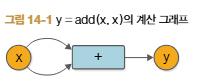

어떤 함수 `(Function 클래스의 인스턴스)`가 `Mytorch` 인스턴스를 생성하면, 그 함수는 결과로 생성된 Mytorch 인스턴스의 생성자 역할을 하게 됩니다.

생성된 결과 인스턴스는 그 함수(생성자 함수)의 `주소를 creator 속성에 저장`합니다. 이를 통해 이 Mytorch 인스턴스가 어떤 연산에 의해 만들어졌는지 `추적`할 수 있습니다.

이렇게 추적된 정보는 역전파 시에 사용됩니다. 역전파가 일어날 때, Mytorch 인스턴스는 자신을 만든 함수를 통해 그 이전 입력들로 역전파를 계속 추적할 수 있게 됩니다.

이 구조는 딥러닝 프레임워크에서 자동 미분(autograd)을 구현할 때 매우 중요하며, 함수의 관계와 기울기 계산을 효율적으로 처리할 수 있게 도와줍니다.

In [43]:
import numpy as np


class Mytorch:
    """ 
    Mytorch 클래스는 데이터와 기울기를 저장하는 클래스입니다.
    
    Attributes:
        data (np.ndarray): 변수의 데이터를 저장합니다.
        grad (np.ndarray): 변수의 기울기를 저장합니다.
        creator (Function): 이 변수를 생성한 함수를 저장합니다.
    """
    
    def __init__(self, data):
        """
        Mytorch 객체를 초기화합니다.

        Args:
            data (np.ndarray or None): 변수의 데이터로 사용할 NumPy 배열.
        
        Raises:
            TypeError: 입력 데이터가 NumPy 배열이 아닌 경우.
        """
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None # 본인의 영향도를 저장함 
        self.creator = None # 본인을 만든 생성자 함수를 주소를 저장

    def set_creator(self, func):
        """ 
        이 변수를 생성한 함수를 설정합니다.

        Args:
            func (Function): 이 변수를 생성한 함수.
        """
        self.creator = func

    def cleargrad(self):
        """ 
        기울기를 초기화합니다.
        """
        #! 기울기 초기화
        self.grad = None

    def backward(self):
        """
        역전파를 수행하여 기울기를 계산합니다.
        """
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs): # 각 Mytorch 인스턴스에 맵핑 

                #! 현제 인스턴스가 기울기를 가지고 있는지 확인하기.
                #! 본인을 재 사용할때 중요
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx 
                    # 같은 주소를 참조하는 인스턴스가 이미 미분값을 가지고 있다면 이를 또 더해 줌

                if x.creator is not None:
                    funcs.append(x.creator)


def as_array(x):
    """
    스칼라 값을 NumPy 배열로 변환합니다.

    Args:
        x (scalar or np.ndarray): 변환할 값.

    Returns:
        np.ndarray: 입력이 스칼라인 경우 배열로 변환된 값.
    """
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    """ 
    Function 클래스는 사용자 정의 함수의 기본 클래스입니다.
    
    Methods:
        forward(xs): 주어진 입력에 대해 순전파를 수행합니다.
        backward(gys): 주어진 기울기에 대해 역전파를 수행합니다.
    """
    
    def __call__(self, *inputs):
        """
        함수 호출을 처리합니다.

        Args:
            *inputs (Mytorch): 입력 변수들.
        
        Returns:
            Mytorch or tuple of Mytorch: 출력 변수를 반환합니다.
        """
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Mytorch(as_array(y)) for y in ys]

        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, *xs):
        """ 
        주어진 입력에 대해 순전파를 수행합니다.
        서브클래스에서 구현해야 합니다.
        
        Args:
            *xs: 순전파에 사용할 입력들.
        
        Returns:
            Output: 순전파 결과.
        """
        raise NotImplementedError()

    def backward(self, gys):
        """ 
        주어진 기울기에 대해 역전파를 수행합니다.
        서브클래스에서 구현해야 합니다.
        
        Args:
            gys: 입력 기울기.
        
        Returns:
            List of np.ndarray: 입력에 대한 기울기.
        """
        raise NotImplementedError()


class Add(Function):
    """ 
    두 변수를 더하는 클래스입니다.
    """
    
    def forward(self, x0, x1):
        """
        두 입력을 더합니다.

        Args:
            x0 (np.ndarray): 첫 번째 입력.
            x1 (np.ndarray): 두 번째 입력.

        Returns:
            np.ndarray: 두 입력의 합.
        """
        y = x0 + x1
        return y

    def backward(self, gy):
        """
        두 입력에 대한 기울기를 반환합니다.

        Args:
            gy (np.ndarray): 출력 기울기.

        Returns:
            tuple: 두 입력의 기울기.
        """
        return gy, gy


def add(x0, x1):
    """
    두 Mytorch 객체를 더하는 함수입니다.

    Args:
        x0 (Mytorch): 첫 번째 입력 Mytorch.
        x1 (Mytorch): 두 번째 입력 Mytorch.

    Returns:
        Mytorch: 두 입력의 합을 포함하는 새로운 Mytorch.
    
    Example:
        >>> x0 = Mytorch(np.array(2.0))
        >>> x1 = Mytorch(np.array(3.0))
        >>> z = add(x0, x1)
        >>> print(z.data)  # 출력: 5.0
    """
    return Add()(x0, x1)


# 사용 예시
x = Mytorch(np.array(3.0))
y = add(x, x)
y.backward()
print(x.grad)  # 출력: 2.0

# 기울기를 초기화하고 다시 계산
x = Mytorch(np.array(3.0))  # 또는 x.cleargrad()
y = add(add(x, x), x)
y.backward()
print(x.grad)  # 출력: 3.0


2.0
3.0


In [44]:
# 사용 예시
x = Mytorch(np.array([3.0,2.0]))
y = add(x, x)
y.backward()
print(x.grad) 

[2. 2.]


### 1. 순전파 (Forward Pass)

```python
x = Mytorch(np.array([3.0, 2.0]))
rs = square(x)  # square 함수를 적용
print(rs.data)  # 출력: [9.0, 4.0]

- x의 데이터는 np.array([3.0, 2.0])이고, square 함수를 적용하여 rs.data = np.array([9.0, 4.0])가 됩니다.

- 이 과정에서 Mytorch 객체 rs는 np.array([9.0, 4.0])을 저장하고, 이를 생성한 함수 Square 객체를 creator로 기록합니다.
```
###  2. 역전파 (Backward Pass)
```python
코드 복사
rs.backward()  # 역전파를 수행
print(x.grad)  # 출력: [6.0, 4.0]

- 역전파가 시작되면 rs.grad는 초기화되지 않았으므로, 기본적으로 np.ones_like(rs.data)가 기울기로 할당됩니다.
즉, rs.grad = np.array([1.0, 1.0])이 됩니다.

- 그다음 Square 클래스의 backward 메서드가 호출되어 입력에 대한 기울기가 계산됩니다.
```

### 3. Square 클래스의 backward 메서드
```python
코드 복사
def backward(self, gy):
    x = self.inputs[0].data  # x는 np.array([3.0, 2.0])
    gx = 2 * x * gy  # 제곱 함수의 역전파
    return gx
- x = np.array([3.0, 2.0])이고, gy = np.array([1.0, 1.0])입니다.

- 역전파 과정에서 입력에 대한 기울기를 계산하는 식은 gx = 2 * x * gy입니다.
gx = 2 * [3.0, 2.0] * [1.0, 1.0]
따라서 gx = [6.0, 4.0]이 됩니다.

- 이 값 gx가 다시 x.grad로 저장됩니다. 즉, x.grad = np.array([6.0, 4.0])이 됩니다.
```

## 복잡한 계산 그래프

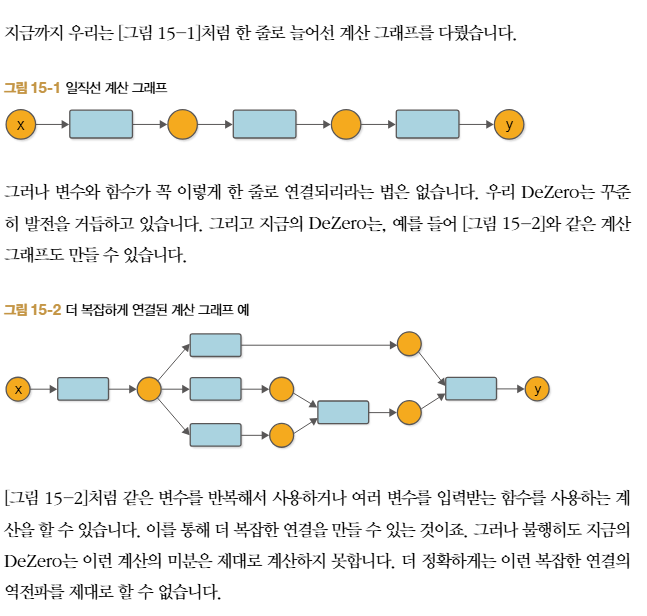

각 노드가 어떤 함수로부터 생성되었는지를 creator로 추적하지만, 순서에 따라 역전파를 제대로 수행하지 못하는 것이 문제.


## 해결 방안: 함수 호출 순서 추적

함수의 생성 순서를 기억하고, 역전파를 진행할 때 함수 호출 순서에 따라 처리해야 합니다. 이를 위해서는 backward에서 함수들이 연결된 순서대로 처리되도록 해야 합니다.

## 해결 방법: Topological Sorting (위상 정렬)
함수 호출 시, 생성된 노드를 스택에 저장하고, 역전파할 때 스택에서 꺼내면서 함수가 호출된 순서대로 처리합니다.
역전파가 진행될 때, 먼저 마지막으로 호출된 함수부터 시작해 역방향으로 진행해야 하므로, 스택을 이용해 함수들을 차례대로 추적합니다.

In [45]:
import numpy as np


class Mytorch:
    """ 
    Mytorch 클래스는 데이터와 기울기를 저장하는 클래스입니다.
    
    Attributes:
        data (np.ndarray): 변수의 데이터를 저장합니다.
        grad (np.ndarray): 변수의 기울기를 저장합니다.
        creator (Function): 이 변수를 생성한 함수를 저장합니다.
        generation (int): 이 변수의 생성 세대를 저장합니다.
    """
    
    def __init__(self, data):
        """
        Mytorch 객체를 초기화합니다.

        Args:
            data (np.ndarray or None): 변수의 데이터로 사용할 NumPy 배열.
        
        Raises:
            TypeError: 입력 데이터가 NumPy 배열이 아닌 경우.
        """
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None
        
        #! 함수에서 처음엔 0으로 초기화 함.
        self.generation = 0 # 위상정렬을 위한 인스턴스의 생성된 번호

    def set_creator(self, func):
        """ 
        이 변수를 생성한 함수를 설정합니다.

        Args:
            func (Function): 이 변수를 생성한 함수.
        """
        #! 생성자를 통해서 만들어진 output 인스턴스들은 세대가 증가함.
        self.creator = func
        self.generation = func.generation + 1 
        # 맨 처음 함수의 세대값은 0임
        # 함수를 통해 생성된 인스턴스는 세대를 증가시킴
    def cleargrad(self):
        """ 
        기울기를 초기화합니다.
        """
        self.grad = None

    def backward(self):
        """
        역전파를 수행하여 기울기를 계산합니다.
        """
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f): # 본인이 생성 될때까지 의 위상값들을 정렬함 함수
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                #! 만들어진 세대들의 우선순위를 정렬함.
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator) # 체인룰로 본인이 생성 될때까지 의 위상값들을 정렬함 함수


def as_array(x):
    """
    스칼라 값을 NumPy 배열로 변환합니다.

    Args:
        x (scalar or np.ndarray): 변환할 값.

    Returns:
        np.ndarray: 입력이 스칼라인 경우 배열로 변환된 값.
    """
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    """ 
    Function 클래스는 사용자 정의 함수의 기본 클래스입니다.
    
    Methods:
        forward(xs): 주어진 입력에 대해 순전파를 수행합니다.
        backward(gys): 주어진 기울기에 대해 역전파를 수행합니다.
    """
    
    def __call__(self, *inputs):
        """
        함수 호출을 처리합니다.

        Args:
            *inputs (Mytorch): 입력 변수들.
        
        Returns:
            Mytorch or tuple of Mytorch: 출력 변수를 반환합니다.
        """
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Mytorch(as_array(y)) for y in ys]

        self.generation = max([x.generation for x in inputs])
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, *xs):
        """ 
        주어진 입력에 대해 순전파를 수행합니다.
        서브클래스에서 구현해야 합니다.
        
        Args:
            *xs: 순전파에 사용할 입력들.
        
        Returns:
            Output: 순전파 결과.
        """
        raise NotImplementedError()

    def backward(self, gys):
        """ 
        주어진 기울기에 대해 역전파를 수행합니다.
        서브클래스에서 구현해야 합니다.
        
        Args:
            gys: 입력 기울기.
        
        Returns:
            List of np.ndarray: 입력에 대한 기울기.
        """
        raise NotImplementedError()


class Square(Function):
    """ 
    입력을 제곱하는 함수입니다.
    """
    
    def forward(self, x):
        """
        입력 값을 제곱합니다.

        Args:
            x (np.ndarray): 입력 값.

        Returns:
            np.ndarray: 제곱한 결과.
        """
        y = x ** 2
        return y

    def backward(self, gy):
        """
        입력에 대한 기울기를 계산합니다.

        Args:
            gy (np.ndarray): 출력 기울기.

        Returns:
            np.ndarray: 입력에 대한 기울기.
        """
        x = self.inputs[0].data #! 제곱 노드는 항상 값을 하나를 받기 때문에 [0] 임
        gx = 2 * x * gy
        return gx


def square(x):
    """
    입력 값을 제곱하는 함수입니다.

    Args:
        x (Mytorch): 입력 변수.

    Returns:
        Mytorch: 제곱한 결과를 포함하는 새로운 Mytorch 객체.
    
    Example:
        >>> x = Mytorch(np.array(2.0))
        >>> y = square(x)
        >>> print(y.data)  # 출력: 4.0
    """
    return Square()(x)


class Add(Function):
    """ 
    두 입력을 더하는 함수입니다.
    """
    
    def forward(self, x0, x1):
        """
        두 입력을 더합니다.

        Args:
            x0 (np.ndarray): 첫 번째 입력.
            x1 (np.ndarray): 두 번째 입력.

        Returns:
            np.ndarray: 두 입력의 합.
        """
        y = x0 + x1
        return y

    def backward(self, gy):
        """
        두 입력에 대한 기울기를 반환합니다.

        Args:
            gy (np.ndarray): 출력 기울기.

        Returns:
            tuple: 두 입력의 기울기.
        """
        return gy, gy


def add(x0, x1):
    """
    두 Mytorch 객체를 더하는 함수입니다.

    Args:
        x0 (Mytorch): 첫 번째 입력 Mytorch.
        x1 (Mytorch): 두 번째 입력 Mytorch.

    Returns:
        Mytorch: 두 입력의 합을 포함하는 새로운 Mytorch.
    
    Example:
        >>> x0 = Mytorch(np.array(2.0))
        >>> x1 = Mytorch(np.array(3.0))
        >>> z = add(x0, x1)
        >>> print(z.data)  # 출력: 5.0
    """
    return Add()(x0, x1)



미분 $(x^2)^2+(x^2)^2$

In [46]:

# 사용 예시
x = Mytorch(np.array(2.0))
a = square(x)
y = add(square(a), square(a))
y.backward()


In [47]:
print(y.data)  # 출력: 16.0
print(x.grad)  # 출력: 8.0

32.0
64.0


## 메모리 관리와 순환 참조

### 약한 참조(Weak Reference)의 장점과 활용

#### 장점

1. **메모리 절약**: 
   - 일반적인 객체 참조는 해당 객체가 가비지 컬렉션의 대상이 되지 않도록 방지합니다. 반면, 약한 참조는 객체를 참조하고 있더라도 다른 곳에서 해당 객체가 더 이상 필요하지 않다면 메모리에서 해제될 수 있습니다.
   - 이를 통해, 메모리 사용량을 줄이고 메모리 누수를 방지할 수 있습니다.

2. **순환 참조 방지**:
   - 일반적인 참조를 사용하면 두 객체가 서로를 참조하는 순환 참조가 발생할 수 있습니다. 이 경우 가비지 컬렉터가 두 객체를 해제하지 못해 메모리 누수가 발생할 수 있습니다. 약한 참조를 사용하면 이러한 문제를 피할 수 있습니다.

#### 코드에서의 활용

위 코드에서는 `Function` 클래스의 `outputs` 리스트에 약한 참조를 사용하여, 함수의 출력값(`Variable` 인스턴스)을 저장하고 있습니다. 이를 통해:

- 함수가 끝나고 출력값이 더 이상 필요하지 않게 될 때, 메모리가 자동으로 해제될 수 있습니다.
- 이 방식은 특히 많은 수의 함수 호출이 일어나는 경우에 유용하여, 이전의 출력값이 더 이상 필요 없을 때 메모리를 효율적으로 관리할 수 있게 해줍니다.

#### 요약

- 약한 참조는 메모리 관리에 도움을 주며, 메모리 누수 및 순환 참조 문제를 예방합니다.
- 이 접근법을 통해 인스턴스가 생성될 때마다 메모리를 절약하고, 이전 인스턴스가 더 이상 필요하지 않을 때 그 메모리를 해제할 수 있게 됩니다.


### 1. 동적 속성 추가
- 파이썬에서는 클래스에 속성을 미리 정의하지 않고도 인스턴스에서 속성을 추가할 수 있습니다. 즉, 인스턴스를 생성한 후에도 자유롭게 속성을 정의하고 수정할 수 있습니다.

In [48]:
class obj():
    pass

a=obj()
b=obj()
c=obj()

a.b=b #! a 객체에 'b'라는 속성을 추가하고, 값으로 b 객체를 할당, 파이썬에서 제공하는 기능
b.c=c

a=b=c=None

In [49]:
class obj():
    pass

a=obj()
b=obj()
c=obj()

a.b=b
b.c=c
c.a=a

a=b=c=None

In [50]:
import weakref
a=np.array([1,2,3])
b=weakref.ref(a)
b()

array([1, 2, 3])

In [51]:
a=None
b

<weakref at 0x000002F77FB16C00; to 'numpy.ndarray' at 0x000002F77FB311D0>

In [52]:
a=None
b=None
b #! 주피터셀의 개별적인 기억장치 때문.

In [53]:
import weakref
import numpy as np


class Mytorch:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0  # 이 줄은 문제가 없지만 아래의 메서드에서 활용해야 함

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1  # 생성자 함수의 넘버를 가져옴

    def cleargrad(self):
        self.grad = None

    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Mytorch(as_array(y)) for y in ys]

        # Update this part to set the generation of the current function
        self.generation = max([x.generation for x in inputs]) if inputs else 0
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = [weakref.ref(output) for output in outputs]
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        gx = 2 * x * gy
        return gx


def square(x):
    return Square()(x)



In [54]:
# Example of using the defined classes
for i in range(10):
    x = Mytorch(np.random.rand(100000))
    y = square(square(x))  # Now this should work without errors

In [55]:
!pip install memory_profiler


In [52]:
import numpy as np
from memory_profiler import memory_usage
import weakref

class Mytorch:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Mytorch(as_array(y)) for y in ys]

        self.generation = max([x.generation for x in inputs])
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = [weakref.ref(output) for output in outputs]
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()

class Add(Function):
    def forward(self, x0, x1):
        return x0 + x1

    def backward(self, gy):
        return gy, gy  # 두 개의 입력에 대해 동일한 기울기를 반환

def add(x0, x1):
    return Add()(x0, x1)

class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        gx = 2 * x * gy
        return gx

def square(x):
    return Square()(x)

def test_memory():
    for i in range(10):
        x = Mytorch(np.random.randn(10000))  # big data
        y = square(square(square(x)))

# Memory profiling
mem_usage = memory_usage((test_memory, ))
print("Memory usage: ", mem_usage)
# 모든 시점에서 메모리 사용량이 같다는 것은, 함수 실행 중에 메모리 사용량이 일정하다는 것을 의미합니다. 
# 즉, 각 호출 시점마다 메모리 사용량이 변화하지 않고 약 50.6MB로 유지되고 있습니다.

Memory usage:  [101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.2734375, 101.27343

In [53]:
len(mem_usage)

78

## 메모리 절약

In [54]:
c0,c1= Mytorch(np.array(1.0)),Mytorch(np.array(1.0))
t=add(c0,c1)
y=add(c0,t)
y.backward()

print(y.grad,t.grad,c0.grad,c1.grad) # 모든 요소들이 미분값을 기억하고있음 메모리적으로 아까움

1.0 1.0 2.0 1.0


In [ ]:
import weakref
import numpy as np
import contextlib


class Config:
    enable_backprop = True


@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)


def no_grad():
    return using_config('enable_backprop', False)


class Mytorch:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            # ! 순환을 돌면서 출력의 기울기는 이전 단계로 전달하고, 
            # ! retain_grad가 False일 경우 현재 출력의 기울기를 삭제하여 메모리를 해제합니다.
            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # 약한 참조로 인해 None으로 하면 메모리가 삭제 됨


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Mytorch(as_array(y)) for y in ys]

        #! 다음 config 의 값에 따라 역전파 여부를 결정한다.
        if Config.enable_backprop: # 학습 과정에서만 미분값들을 저장함
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        gx = 2 * x * gy
        return gx


def square(x):
    return Square()(x)


class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    return Add()(x0, x1)




In [56]:
Config.enable_backprop =True
x = Mytorch(np.ones((100,100,100)))
y= square(square(x))
y.backward()

In [57]:
Config.enable_backprop =False
x = Mytorch(np.ones((100,100,100)))
y= square(square(x))
y.backward() # ! 다음 역전파 사용여부가 False 이기 때문에 backward() 자체가 안된다.

AttributeError: 'NoneType' object has no attribute 'generation'

In [58]:

# ! 역전파 비활모드에서 with를 빠져 나오면 다시 활성화 모드가 된다.
with using_config('enable_backprop', False):
    x = Mytorch(np.array(2.0))
    y = square(x)

with no_grad():  # torch_no_grad의 원리
    x = Mytorch(np.array(2.0))
    y = square(x)

In [59]:

# 기울기 확인
print(x.grad)  # 출력: None


None


## 변수 개선

In [60]:
import weakref  # 약한 참조를 위해 사용
import numpy as np  # NumPy 라이브러리 임포트
import contextlib  # 컨텍스트 매니저를 위한 라이브러리 임포트


# 설정을 저장하는 클래스
class Config:
    enable_backprop = True  # 역전파 기능 활성화 기본값


# 설정을 변경하는 컨텍스트 매니저
@contextlib.contextmanager
def using_config(name, value):
    # ! 이전 값을 저장
    old_value = getattr(Config, name)
    # ! 설정 값 변경
    setattr(Config, name, value)
    try:
        yield  # ! 변경된 설정 값으로 블록 실행
    finally:
        # ! 원래 설정 값으로 복원
        setattr(Config, name, old_value)


# 역전파 비활성화를 위한 함수
def no_grad():
    return using_config('enable_backprop', False)  # 역전파를 비활성화


# Mytorch 클래스 정의
class Mytorch:
    def __init__(self, data, name=None):
        # 데이터가 None이 아닐 경우 데이터 타입 확인
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data  # ! 데이터 타입은 ndarray
        self.name = name  # 변수 이름 저장
        self.grad = None  # 기울기 초기화
        self.creator = None  # 생성자 초기화
        self.generation = 0  # 세대 초기화

    # 속성: 데이터의 shape
    @property
    def shape(self):
        return self.data.shape

    # 속성: 데이터의 차원 수
    @property
    def ndim(self):
        return self.data.ndim

    # 속성: 데이터의 전체 원소 수
    @property
    def size(self):
        return self.data.size

    # 속성: 데이터의 타입
    @property
    def dtype(self):
        return self.data.dtype

    # __len__ 메서드: 데이터의 길이 반환
    def __len__(self):
        return len(self.data)

    # __repr__ 메서드: 변수의 문자열 표현
    def __repr__(self):
        if self.data is None:
            return 'Mytorch(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)  # 줄 바꿈 시 정렬
        return 'Mytorch(' + p + ')'

    # 생성자 설정 메서드
    def set_creator(self, func):
        self.creator = func  # 생성자 함수 설정
        self.generation = func.generation + 1  # 세대 업데이트

    # 기울기 초기화 메서드
    def cleargrad(self):
        self.grad = None

    # 역전파 메서드
    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)  # 기울기가 None일 경우 초기화

        funcs = []  # 함수 목록
        seen_set = set()  # 중복 방지 집합

        # 함수 추가 메서드
        def add_func(f):
            if f not in seen_set:
                funcs.append(f)  # 함수 추가
                seen_set.add(f)  # 집합에 추가
                funcs.sort(key=lambda x: x.generation)  # 세대에 따라 정렬

        add_func(self.creator)  # 현재 변수의 생성자 추가

        while funcs:  # 함수가 남아 있을 경우
            f = funcs.pop()  # 마지막 함수 꺼내기

            #! f.outputs는 Mytorch 객체들의 리스트
            #! output().grad는 각 Mytorch 객체에서 기울기를 가져오는 방식

            gys = [output().grad for output in f.outputs]  # 출력의 기울기 가져오기
            gxs = f.backward(*gys)  # 역전파 수행
            if not isinstance(gxs, tuple):
                gxs = (gxs,)  # 튜플이 아닐 경우 튜플로 변환

            for x, gx in zip(f.inputs, gxs):  # 입력과 기울기 쌍을 반복
                if x.grad is None:
                    x.grad = gx  # 기울기가 None일 경우 기울기 설정
                else:
                    x.grad = x.grad + gx  # 기존 기울기에 더하기

                if x.creator is not None:
                    add_func(x.creator)  # 생성자가 있을 경우 추가

            if not retain_grad:  # retain_grad가 False일 경우
                for y in f.outputs:
                    y().grad = None  # 출력의 기울기 초기화


# 배열 형식 변환 함수
def as_array(x):
    if np.isscalar(x):
        return np.array(x)  # 스칼라일 경우 배열로 변환
    return x  # 이미 배열인 경우 그대로 반환


# 함수 클래스 정의
class Function:
    def __call__(self, *inputs):
        # ! 데이터 자체를 add 아니면 다 리스트로 감싼는 역할을 한다.
        # ! [array([[1, 2, 3],
        # ![4, 5, 6]])]
        xs = [x.data for x in inputs]  # 입력 데이터 추출

        print(xs)

        ys = self.forward(*xs)  # 순전파 수행

        print(ys)

        if not isinstance(ys, tuple):
            ys = (ys,)  # 튜플이 아닐 경우 튜플로 변환

        # ! ys 데이터가 한방에 들어감, mytorch 인스턴스가 두개일대 y가 풀어짐 -> add일 경우
        outputs = [Mytorch(as_array(y)) for y in ys]  # 출력 변수 생성
        # ! 데이터를 리스트로 감싼는 역할을 한다.
        print(outputs)

        if Config.enable_backprop:  # 역전파 기능 활성화 시
            self.generation = max([x.generation for x in inputs])  # 세대 설정
            for output in outputs:
                output.set_creator(self)  # 출력 변수의 생성자 설정
            self.inputs = inputs  # 입력 저장

            #! outputs은 즉 함수를 통해 생성된 결과를 추적하고 있고 이는 역전파에연결을 위함
            self.outputs = [weakref.ref(output) for output in outputs]  # 약한 참조 저장
        
        # ! outputs[0] 이 반환되는 것임
        return outputs if len(outputs) > 1 else outputs[0]  # 출력 반환

    def forward(self, xs):
        raise NotImplementedError()  # 서브클래스에서 구현해야 함

    def backward(self, gys):
        raise NotImplementedError()  # 서브클래스에서 구현해야 함


# 제곱 함수 클래스 정의
class Square(Function):
    def forward(self, x):
        y = x ** 2  # 제곱 연산
        return y

    def backward(self, gy):
        x = self.inputs[0].data  # 입력 데이터
        gx = 2 * x * gy  # 기울기 계산
        return gx


# 제곱 함수 호출 함수
def square(x):
    return Square()(x)  # Square 클래스 인스턴스 호출

#! data 꺼내옴 저장을 리스트로 감싸줌
#! 데이터를 보내주고 연산함
#! 해당 데이터를 다시 mytorch로 인스턴스 생성후 리스트로 감싸줌
#! 리스트의 길이에 따라 리턴
# [array([[1, 2, 3],
#        [4, 5, 6]])]
# [[ 1  4  9]
#  [16 25 36]]
# [Mytorch([[ 1  4  9]
#           [16 25 36]])]
# Mytorch([[ 1  4  9]
#           [16 25 36]])



# 덧셈 함수 클래스 정의
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1  # 덧셈 연산
        return y

    def backward(self, gy):
        return gy, gy  # 두 입력 모두에 대한 기울기 반환


# 덧셈 함수 호출 함수
def add(x0, x1):
    return Add()(x0, x1)  # Add 클래스 인스턴스 호출


# Mytorch 인스턴스 생성
x = Mytorch(np.array([[1, 2, 3], [4, 5, 6]]),'input_x')  # 2D 배열로 Mytorch 생성

# 결과 출력
print(x.name)  # 변수 이름 출력
print(x.shape)  # 변수의 shape 출력
print(x.data.dtype)  #
print(x.data.__class__)
print(x)  # Mytorch 객체 출력


input_x
(2, 3)
int32
<class 'numpy.ndarray'>
Mytorch([[1 2 3]
          [4 5 6]])


In [61]:
square(x)

[array([[1, 2, 3],
       [4, 5, 6]])]
[[ 1  4  9]
 [16 25 36]]
[Mytorch([[ 1  4  9]
          [16 25 36]])]


Mytorch([[ 1  4  9]
          [16 25 36]])

In [62]:
add(Mytorch(np.array([[1, 2, 3], [4, 5, 6]]),'input_x1'),Mytorch(np.array([[1, 2, 3], [4, 5, 6]]),'input_x2'))

[array([[1, 2, 3],
       [4, 5, 6]]), array([[1, 2, 3],
       [4, 5, 6]])]
[[ 2  4  6]
 [ 8 10 12]]
[Mytorch([[ 2  4  6]
          [ 8 10 12]])]


Mytorch([[ 2  4  6]
          [ 8 10 12]])

In [63]:
import numpy as np

arr = np.array([[1, 2, 3], [4, 5, 6]])
print(arr)  # __str__이 호출됩니다.
print(arr.__repr__())  # __repr__이 직접 호출됩니다.


[[1 2 3]
 [4 5 6]]
array([[1, 2, 3],
       [4, 5, 6]])


## 연산자 오버로드

미분 $y=x_0*x_1$

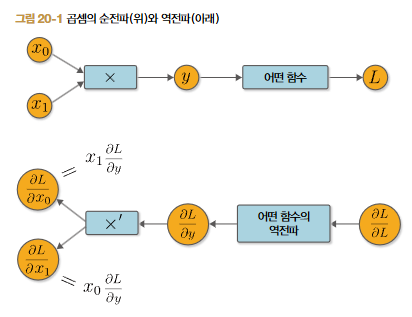

$(a*b)+c$

In [64]:
import weakref
import numpy as np
import contextlib


class Config:
    enable_backprop = True


@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)


def no_grad():
    return using_config('enable_backprop', False)


class Mytorch:  # Replaced Variable with Mytorch
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'Mytorch(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'Mytorch(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Mytorch(as_array(y)) for y in ys]  # Using Mytorch instead of Variable

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        gx = 2 * x * gy
        return gx


def square(x):
    return Square()(x)


class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    return Add()(x0, x1)


class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0


def mul(x0, x1):
    return Mul()(x0, x1)


Mytorch.__add__ = add  # Redefine operator overloading for Mytorch
Mytorch.__mul__ = mul

a = Mytorch(np.array(3.0))  # Use Mytorch instead of Variable
b = Mytorch(np.array(2.0))
c = Mytorch(np.array(1.0))

# y = add(mul(a, b), c)
y = a * b + c  # Now works with Mytorch instances
y.backward()

print(y)
print(a.grad)
print(b.grad)

#! 연산이 호출될 때 자동으로 data 속성을 가져오는 것은 아닙니다. 
#! mul 함수가 호출되면 Mul 클래스에서 forward 메서드를 통해 data 속성에 접근하게 됩니다. 
#! Function 클래스 내부의 forward 메서드는 데이터를 직접 처리하는 부분이기 때문에, 
#! 연산이 발생할 때 data 속성에 접근하여 계산이 이루어집니다.


Mytorch(7.0)
2.0
3.0


In [65]:
b*a

Mytorch(6.0)

## float,int Mytorch 사용하기

In [138]:
import weakref
import numpy as np
import contextlib


class Config:
    enable_backprop = True


@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)


def no_grad():
    return using_config('enable_backprop', False)


class Mytorch:  # Replaced Mytoch with Mytorch
    __array_priority__ = 200 # 기본 넘파이 인스턴스는 0임 우선순위를 잡으려면 0을 제외한 아무값이나 가능

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'Mytorch(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'Mytorch(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref


def as_mytorch(obj):
    if isinstance(obj, Mytorch):  # Changed to Mytorch
        return obj
    return Mytorch(obj)


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs):
        inputs = [as_mytorch(x) for x in inputs]

        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Mytorch(as_array(y)) for y in ys]  # Changed to Mytorch

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    x1 = as_array(x1)
    return Add()(x0, x1)


class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0


def mul(x0, x1):
    x1 = as_array(x1)
    return Mul()(x0, x1)


class Neg(Function):
    def forward(self, x):
        return -x

    def backward(self, gy):
        return -gy


def neg(x):
    return Neg()(x)


class Sub(Function):
    def forward(self, x0, x1):
        y = x0 - x1
        return y

    def backward(self, gy):
        return gy, -gy


def sub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x0, x1)


def rsub(x0, x1):
    x1 = as_array(x1)
    return sub(x1, x0)


class Div(Function):
    def forward(self, x0, x1):
        y = x0 / x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        gx0 = gy / x1
        gx1 = gy * (-x0 / x1 ** 2)
        return gx0, gx1


def div(x0, x1):
    x1 = as_array(x1)
    return Div()(x0, x1)


def rdiv(x0, x1):
    x1 = as_array(x1)
    return div(x1, x0)


class Pow(Function):
    def __init__(self, c):
        self.c = c

    def forward(self, x):
        y = x ** self.c
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        c = self.c

        gx = c * x ** (c - 1) * gy
        return gx


def pow(x, c):
    return Pow(c)(x)



Mytorch.__add__ = add
Mytorch.__radd__ = add
Mytorch.__mul__ = mul
Mytorch.__rmul__ = mul
Mytorch.__neg__ = neg
Mytorch.__sub__ = sub
Mytorch.__rsub__ = rsub
Mytorch.__truediv__ = div
Mytorch.__rtruediv__ = rdiv
Mytorch.__pow__ = pow

In [139]:

# Example usage
x = Mytorch(np.array(2.0))  # Changed to My
x

Mytorch(2.0)

In [140]:
x = Mytorch(np.array(1.0))
y = (x + 3) ** 2
y.backward()

print(y)
print(x.grad)

Mytorch(16.0)
8.0


In [142]:
x = Mytorch(np.array(300.0))
y = np.array([1.0])+x

print(y,x.grad)

Mytorch([301.]) None


### 나머지 Mytorch 연산자들 추가


In [147]:
import weakref
import numpy as np
import contextlib


class Config:
    enable_backprop = True


@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)


def no_grad():
    return using_config('enable_backprop', False)


class Mytorch:
    __array_priority__ = 200

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'mytorh(None)'
        p = str(object=self.data).replace('\n', '\n' + ' ' * 9)
        return 'mytorh(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref


def as_mytorch(obj):
    if isinstance(obj, Mytorch):
        return obj
    return Mytorch(obj)


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs):
        inputs = [as_mytorch(x) for x in inputs]

        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Mytorch(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    x1 = as_array(x1)
    return Add()(x0, x1)


class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0


def mul(x0, x1):
    x1 = as_array(x1)
    return Mul()(x0, x1)


class Neg(Function):
    def forward(self, x):
        return -x

    def backward(self, gy):
        return -gy


def neg(x):
    return Neg()(x)


class Sub(Function):
    def forward(self, x0, x1):
        y = x0 - x1
        return y

    def backward(self, gy):
        return gy, -gy


def sub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x0, x1)


def rsub(x0, x1):
    x1 = as_array(x1)
    return sub(x1, x0)


class Div(Function):
    def forward(self, x0, x1):
        y = x0 / x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        gx0 = gy / x1
        gx1 = gy * (-x0 / x1 ** 2)
        return gx0, gx1


def div(x0, x1):
    x1 = as_array(x1)
    return Div()(x0, x1)


def rdiv(x0, x1):
    x1 = as_array(x1)
    return div(x1, x0)


class Pow(Function):
    def __init__(self, c):
        self.c = c

    def forward(self, x):
        y = x ** self.c
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        c = self.c

        gx = c * x ** (c - 1) * gy
        return gx


def pow(x, c):
    return Pow(c)(x)


Mytorch.__add__ = add
Mytorch.__radd__ = add
Mytorch.__mul__ = mul
Mytorch.__rmul__ = mul
Mytorch.__neg__ = neg
Mytorch.__sub__ = sub
Mytorch.__rsub__ = rsub
Mytorch.__truediv__ = div
Mytorch.__rtruediv__ = rdiv
Mytorch.__pow__ = pow

x = Mytorch(np.array(2.0))
y = -x
print(y)  # variable(-2.0)

y1 = 2.0 - x
y2 = x - 1.0
print(y1)  # variable(0.0)
print(y2)  # variable(1.0)

y = 3.0 / x
print(y)  # variable(1.5)

y = x ** 3
y.backward()
print(y)  # variable(8.0)

mytorh(-2.0)
mytorh(0.0)
mytorh(1.0)
mytorh(1.5)
mytorh(8.0)


### mytorch 임포트 후 사용하기

In [2]:

#! 임포트 후 위 클래스 셀을 다시 실행하기.

from mytorch.class_mytorch import Mytorch
import numpy as np
x=Mytorch(np.array(2.0))
x


mytorch(2.0)

In [3]:
x=Mytorch(2.0)
x

TypeError: <class 'float'>는 지원하지 않는 타입입니다.

In [4]:
# Add import path for the dezero directory.
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))

import numpy as np #! 외부 모듈에서 사용하는 모든 외부 라이브러리는 해당 모듈 내부에서 직접 임포트해야 함.
from mytorch.class_mytorch import Mytorch
from mytorch.class_mytorch import setup_Mytorch

setup_Mytorch()

x = Mytorch(np.array(1.0))
y = (x + 3) ** 2
y.backward()

print(y)
print(x.grad)

mytorch(16.0)
8.0


In [5]:
x = Mytorch(np.array(1.0))
y = (x + 3)
print(y)

mytorch(4.0)


## Sphere 함수

Sphere 함수는 다음과 같이 정의됩니다:

$$
z = x^2 + y^2
$$

---

## Matyas 함수

Matyas 함수는 다음과 같이 정의됩니다:

$$
z = 0.26 \cdot (x^2 + y^2) - 0.48 \cdot x \cdot y
$$

---

## Goldstein 함수

Goldstein 함수는 다음과 같이 정의됩니다:

$$
z = \left(1 + (x + y + 1)^2 \cdot (19 - 14x + 3x^2 - 14y + 6xy + 3y^2)\right) \cdot \left(30 + (2x - 3y)^2 \cdot (18 - 32x + 12x^2 + 48y - 36xy + 27y^2)\right)
$$


In [6]:
def sphere(x, y):
    z = x ** 2 + y ** 2
    return z


def matyas(x, y):
    z = 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y
    return z


def goldstein(x, y):
    z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return z


x = Mytorch(np.array(1.0))
y = Mytorch(np.array(1.0))
z = goldstein(x, y)  # sphere(x, y) / matyas(x, y)
z.backward()
print(x.grad, y.grad)

-5376.0 8064.0


## Define-by-Run vs Define-and-Run

딥러닝 프레임워크에서 모델을 정의하고 실행하는 두 가지 접근 방식인 **Define-by-Run**과 **Define-and-Run**에 대해 설명합니다. 이 두 가지 방식의 차이점은 주로 모델이 어떻게 구성되고 실행되는지에 관한 것입니다.

### Define-by-Run (Dynamic Computation Graph)
- **설명**: 
  - Define-by-Run은 **동적 계산 그래프**를 기반으로 합니다. 즉, 모델의 구조가 실행되는 동안 생성됩니다. 이 방식은 각 반복(iteration)마다 계산 그래프가 다를 수 있습니다. 주로 연구 및 실험적인 환경에서 많이 사용됩니다.
  
- **장점**:
  - **유연성**: 모델을 실행하는 동안 그래프 구조를 변경할 수 있어 복잡한 모델을 쉽게 구현할 수 있습니다.
  - **디버깅 용이**: 각 실행에서 그래프가 생성되므로 중간 결과를 쉽게 확인할 수 있습니다.

#### 예시 (PyTorch 사용)
```python
import torch

# Define a simple model using Define-by-Run
class SimpleModel(torch.nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear = torch.nn.Linear(10, 5)

    def forward(self, x):
        return self.linear(x)

# Create an instance of the model
model = SimpleModel()

# Forward pass with a random input
input_data = torch.randn(1, 10)
output = model(input_data)

print("Output:", output)

```
## Define-and-Run (Static Computation Graph)
- **설명**:
    - Define-and-Run은 **정적 계산 그래프**를 기반으로 합니다. 모델의 구조가 사전에 정의되고, 이후에 실행됩니다. 이 방식은 일반적으로 생산 환경에서 사용되며, 모델을 최적화하고 성능을 높일 수 있는 장점이 있습니다.

- **장점**:
    - **성능 최적화**: 그래프가 사전에 정의되므로 최적화가 가능하여 실행 속도가 빠릅니다.
    - **메모리 효율성**: 그래프가 고정되어 있어 메모리 사용량을 줄일 수 있습니다.

예시 (TensorFlow 사용)

```python
import tensorflow as tf

# Define a simple model using Define-and-Run
class SimpleModel(tf.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear = tf.keras.layers.Dense(5)

    @tf.function
    def __call__(self, x):
        return self.linear(x)

# Create an instance of the model
model = SimpleModel()

# Forward pass with a random input
input_data = tf.random.normal((1, 10))
output = model(input_data)

print("Output:", output)
```

### 요약

- Define-by-Run:

동적 계산 그래프
실행 시 그래프가 정의되며 유연성과 디버깅의 용이성이 특징입니다.
주로 PyTorch와 같은 프레임워크에서 사용됩니다.

- Define-and-Run:

정적 계산 그래프
사전에 그래프가 정의되며 성능 최적화와 메모리 효율성이 특징입니다.
주로 TensorFlow와 같은 프레임워크에서 사용됩니다.
